In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt 
import scipy.stats as stt
import itertools
import emcee

In [105]:
def model(params, t):
    amp, freq, phase, tau = params
    # amp, freq, phase, offset, tau = params
    return amp * np.cos(freq * 2 * np.pi * t + phase) * np.exp(- t / tau)# + offset


def cost(params, t, y):
    return ((model(params, t) - y)**2).sum()


def clean_raw_data(raw, init_cut=500, hit_cut=300, valid_duration=1500):
    """
        Clean raw data
        =====
        raw: raw data taken from experiment
        init cut: remove the amount of data points since start of collection
        hit cut: remove the amount of data since the hammer hit
        valid duration: retained number of data points immediately after the hit cut
    """
    tmp_data = raw[init_cut:]    
    hit_ind = np.argmax(np.abs(tmp_data[:, 2]))
    selected_seg = tmp_data[hit_ind + hit_cut:hit_ind + hit_cut + valid_duration]
    return selected_seg


def reduce_segment(data, target_col=1):
    """
        Reduce data segment by removing takes due to higher samply rate of python
        than the accelerometer
        =====
        data: data to be reduced 
        target_col: column used for identify repeating takes
    """
    reduce_target = data[:, target_col]
    const_split = np.split(data, np.where(np.diff(reduce_target) != 0)[0] + 1)
    reduced_data = np.concatenate([tmp[:1] for tmp in const_split], axis=0)
    return reduced_data


def rms(data:np.ndarray):
    """
    Calculate the rms for an array
    """
    data = data - data.mean()
    return ((data**2).sum() / data.shape[0])**0.5


def log_prior(theta):
    # amp, freq, phase, offset, tau = theta
    amp, freq, phase, tau = theta
    # if (50 < amp < 150) and (9. < freq < 11.) and (0 < phase < 2 * np.pi) and (-20. < offset < 20.) and (0. < tau < 1.):
    if (50 < amp < 150) and (9. < freq < 11.) and (0 < phase < 2 * np.pi) and (0. < tau < 1.):
        return 0
    return -np.inf


def log_likelihood(theta, t, y):
    model_y = model(theta, t)
    return -0.5 * np.sum((model_y - y)**2 / (5 * np.exp(-t / 0.6))**2) # careful on the choice of rms


def log_prob(theta, t, y):
    prior = log_prior(theta)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(theta, t, y)

In [96]:
configs = [1, 2, 3, 5]
takes = [1, 2, 3]
axes_color = ['red', 'blue']
y_col = [1, 2]
fname = "../data/norm_mode_null_test/NullTest_config{}-{}-take{}.npy"
# tmp_data = np.load(f"../data/norm_mode_null_test/NullTest_config{config_no}-{ax_no}-take{take_no}.npy")[500:]

3 red 1


100%|██████████| 40000/40000 [00:19<00:00, 2040.01it/s]


[104.50047474  10.25367536   2.02524676   0.68293549]
[0.55707515 0.00093432 0.00539463 0.00266075]


100%|██████████| 40000/40000 [00:16<00:00, 2427.71it/s]


[5.00120776e+01 1.01348713e+01 2.31492697e-04 5.41107507e-01]
[0.01221188 0.00131214 0.00023075 0.00274566]
3 red 2


100%|██████████| 40000/40000 [00:19<00:00, 2103.36it/s]


[128.39711276  10.22576936   1.76254964   0.66302428]
[0.56607987 0.0007859  0.0044536  0.00212158]


100%|██████████| 40000/40000 [00:16<00:00, 2430.67it/s]


[55.62361819  9.96298578  0.08230317  0.4116505 ]
[21.70831824  0.21024961  0.31768108  0.10601195]
3 red 3


  0%|          | 0/40000 [00:00<?, ?it/s]/home/andrewliu/anaconda3/envs/num-algo/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 40000/40000 [00:19<00:00, 2095.33it/s]


[123.92628815  10.23580827   1.63262811   0.67462984]
[0.56980783 0.00077759 0.00444674 0.00226242]


100%|██████████| 40000/40000 [00:16<00:00, 2408.95it/s]


[54.33876741  9.97404259  0.08098255  0.46066986]
[16.75528998  0.23819666  0.31301578  0.11893365]
3 blue 1


100%|██████████| 40000/40000 [00:19<00:00, 2069.34it/s]


[52.81182224 10.30064491  2.63930501  0.47069113]
[0.77330122 0.00309187 0.01361768 0.00492755]


100%|██████████| 40000/40000 [00:07<00:00, 5572.81it/s]


[245.37908924  10.19361621   1.00266849   0.60202568]
[2.35006381 0.09872845 0.00865507 0.00487267]
3 blue 2


100%|██████████| 40000/40000 [00:16<00:00, 2412.18it/s]


[50.42244625 10.95812353  0.16641826  0.45866928]
[1.17392335 0.16168177 0.27195339 0.0175459 ]


100%|██████████| 40000/40000 [00:07<00:00, 5425.08it/s]


[214.20957817  10.22172976   0.99802035   0.60055454]
[1.87214779 0.07008572 0.00691022 0.00455255]
3 blue 3


100%|██████████| 40000/40000 [00:15<00:00, 2512.76it/s]


[59.3960753  10.82506976  1.10456165  0.40905532]
[5.08817132 0.30220255 0.61674301 0.04442245]


100%|██████████| 40000/40000 [00:07<00:00, 5488.83it/s]


[225.4943128   10.20522554   1.00180195   0.59846365]
[2.02832168 0.0792713  0.01213752 0.00550194]


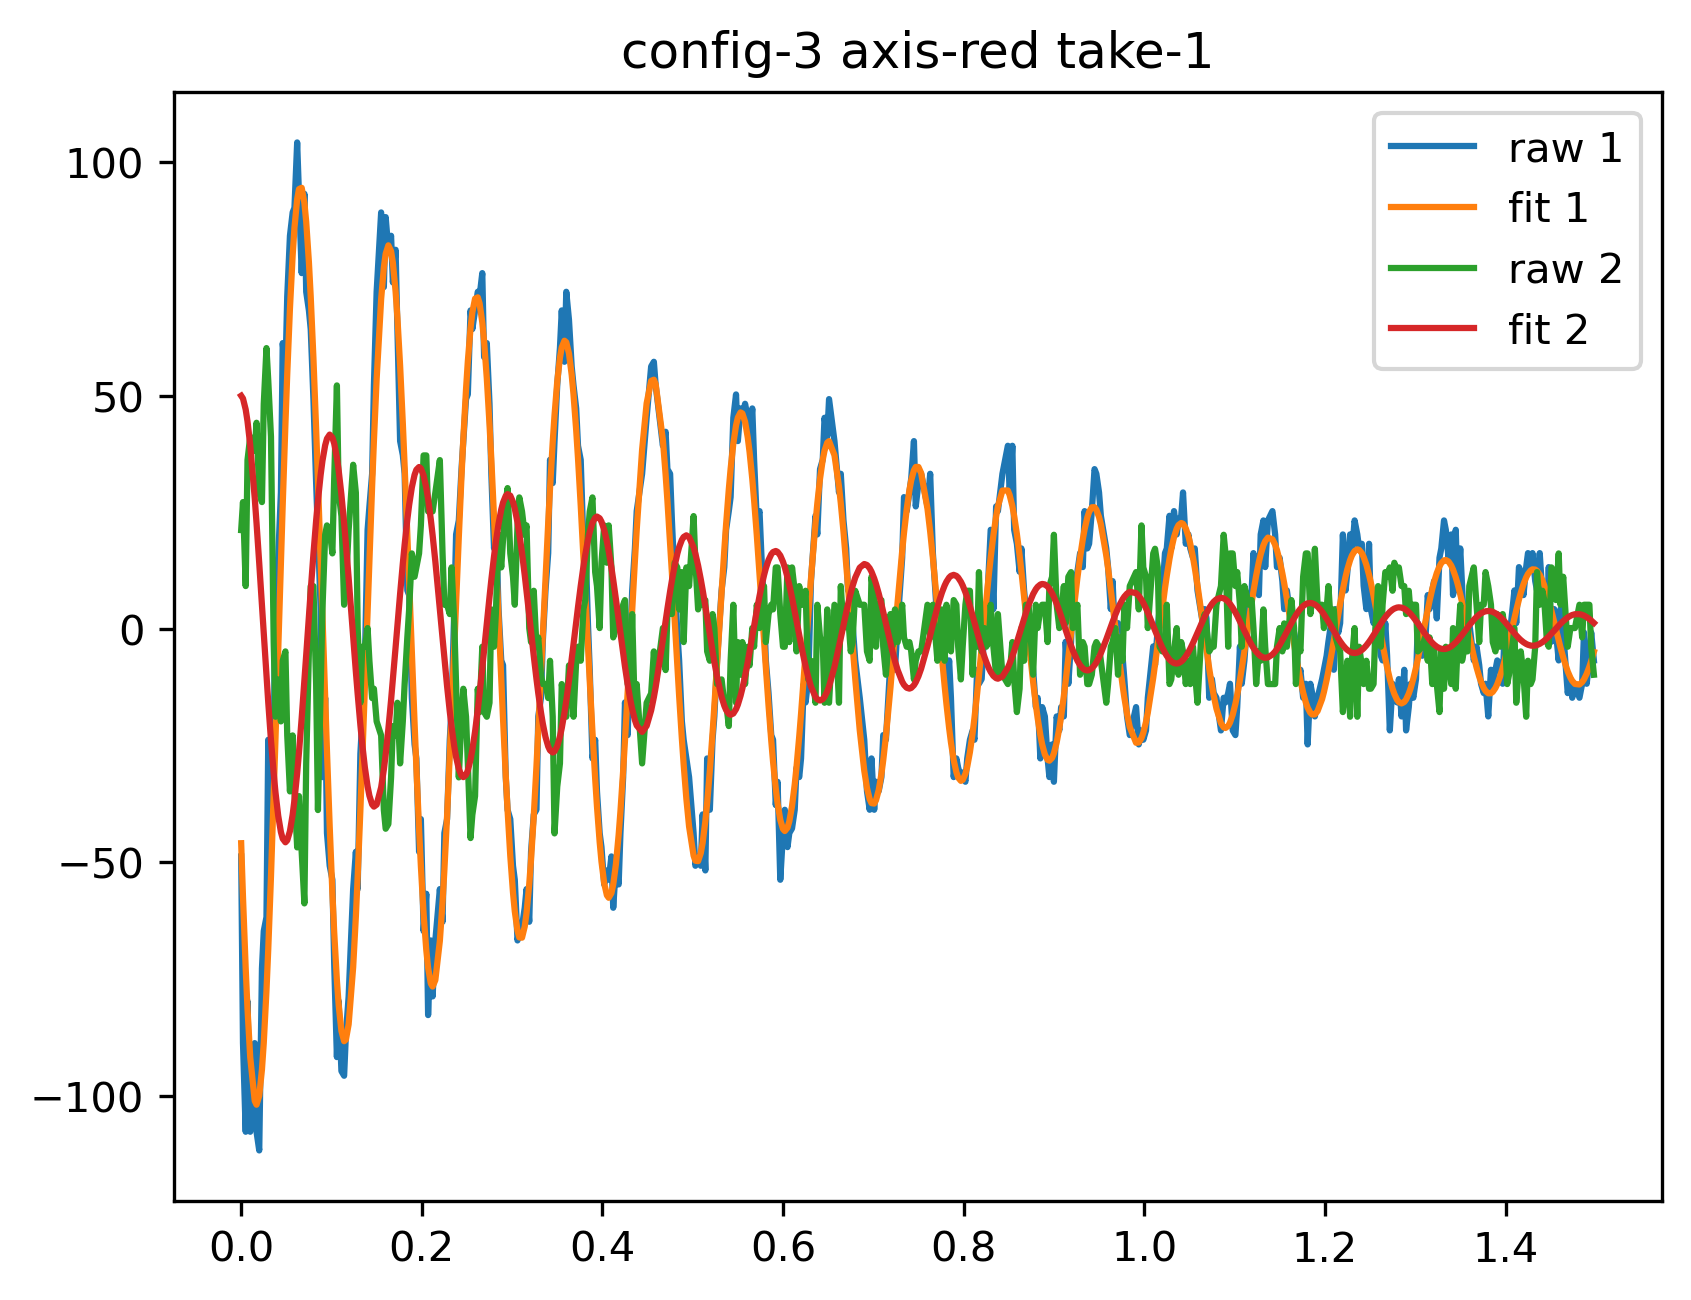

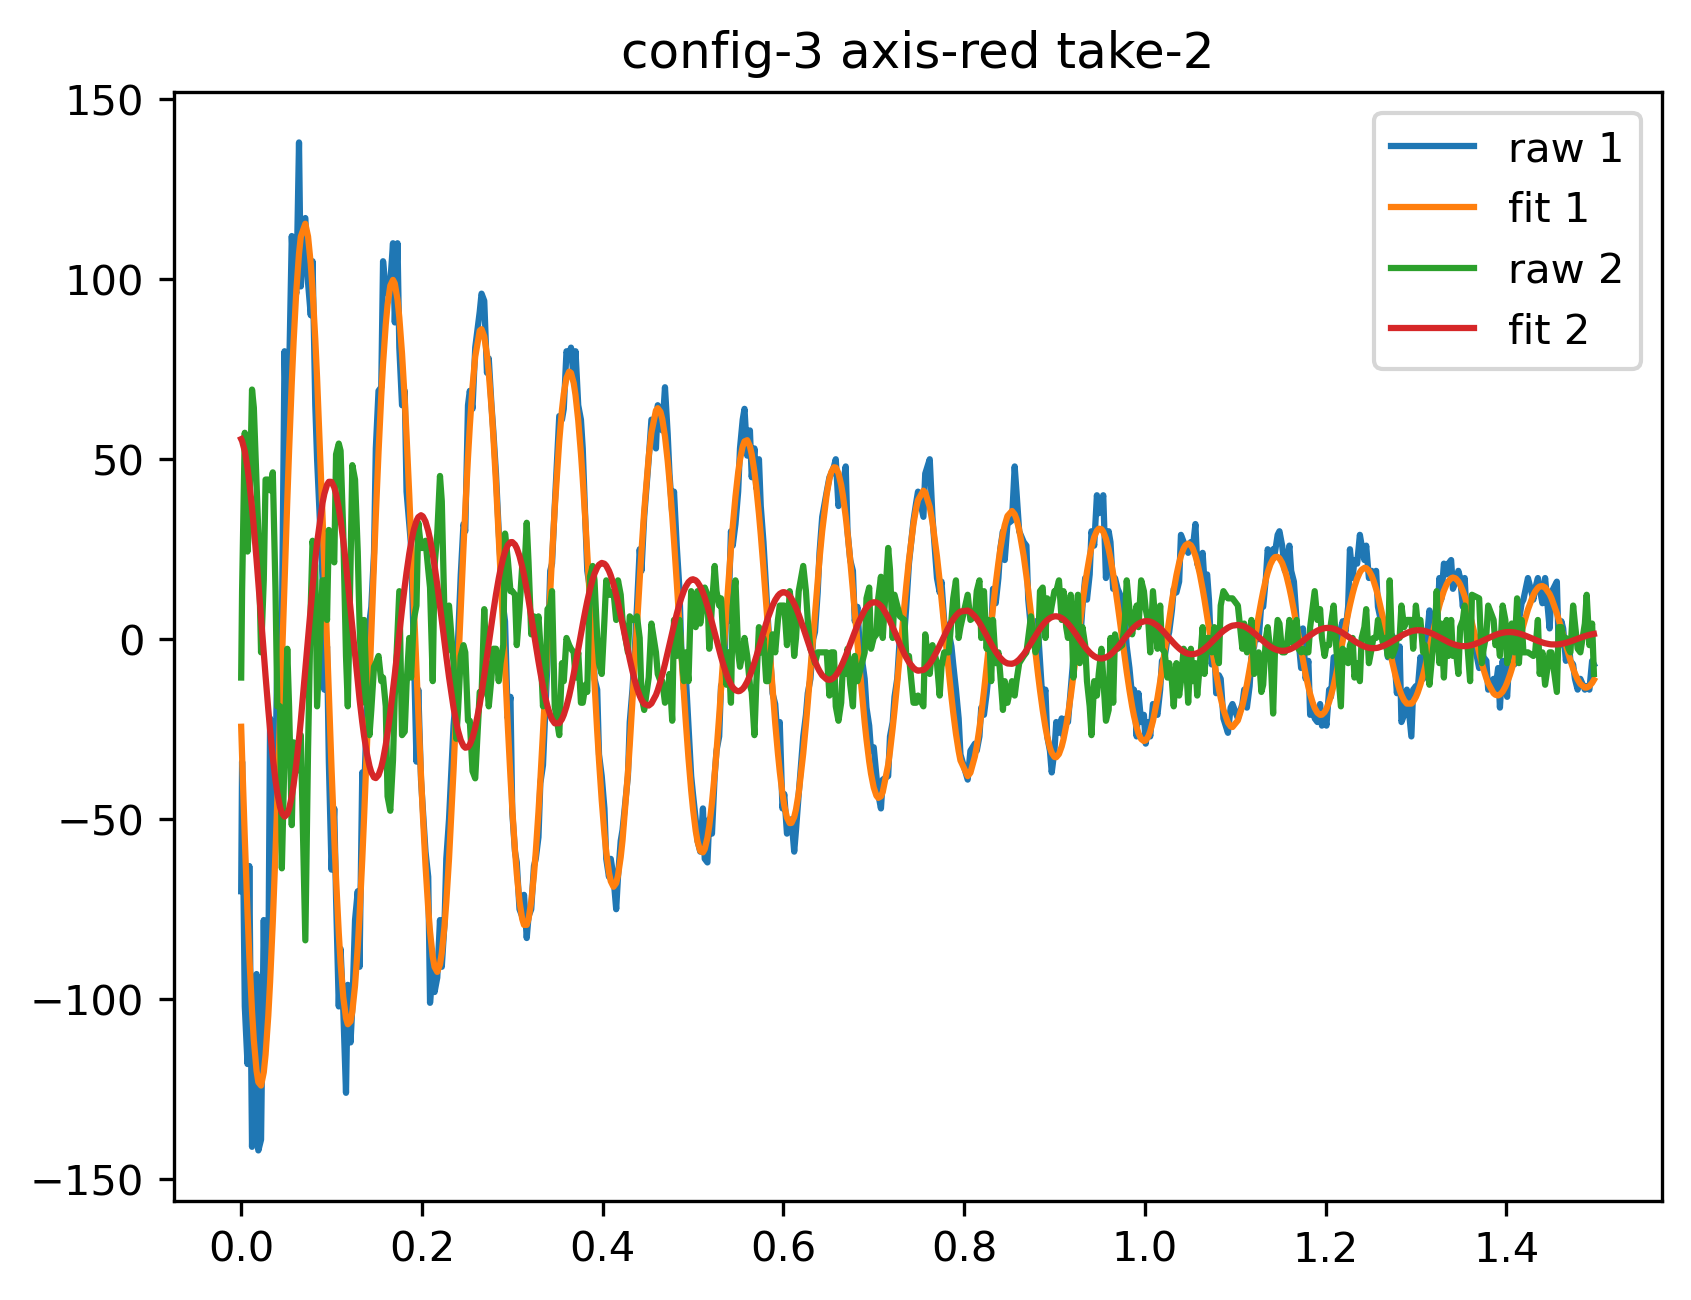

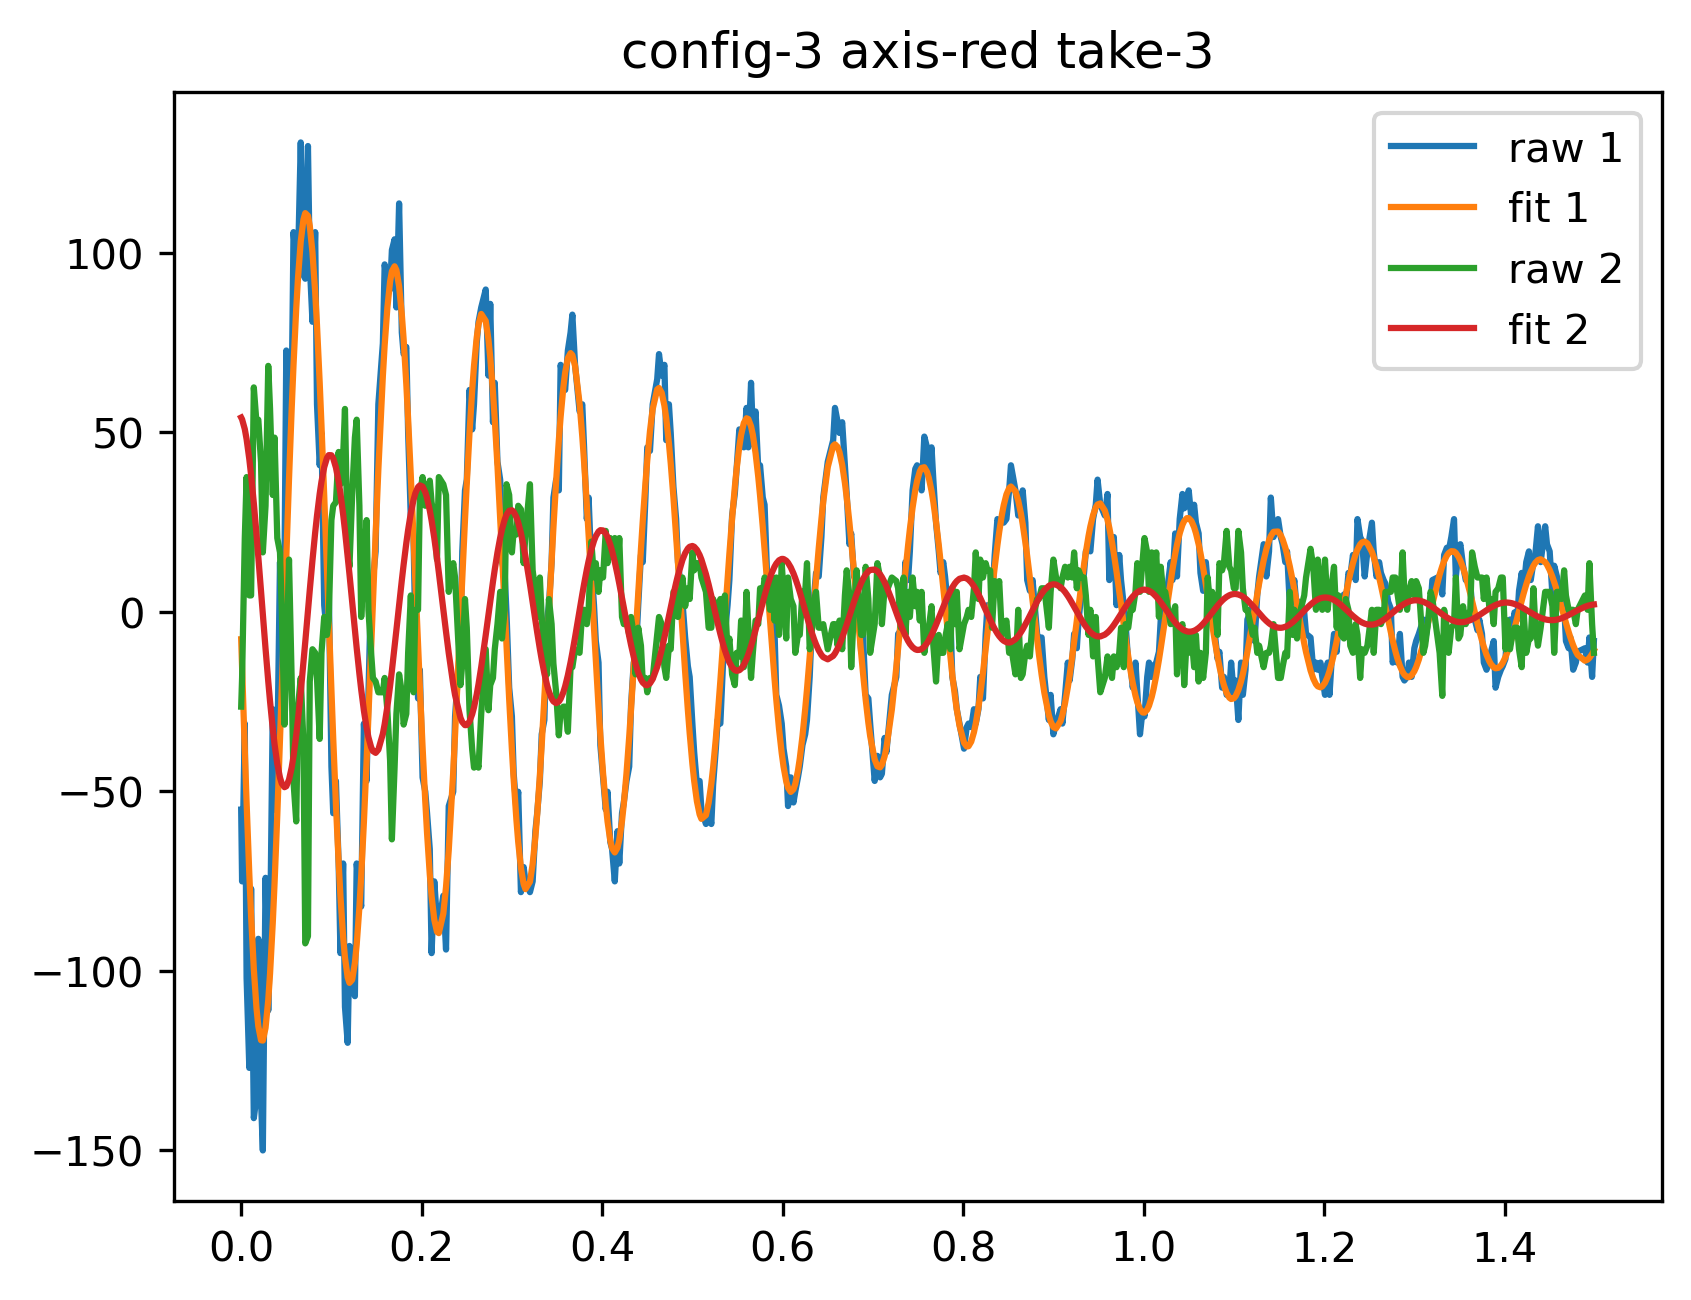

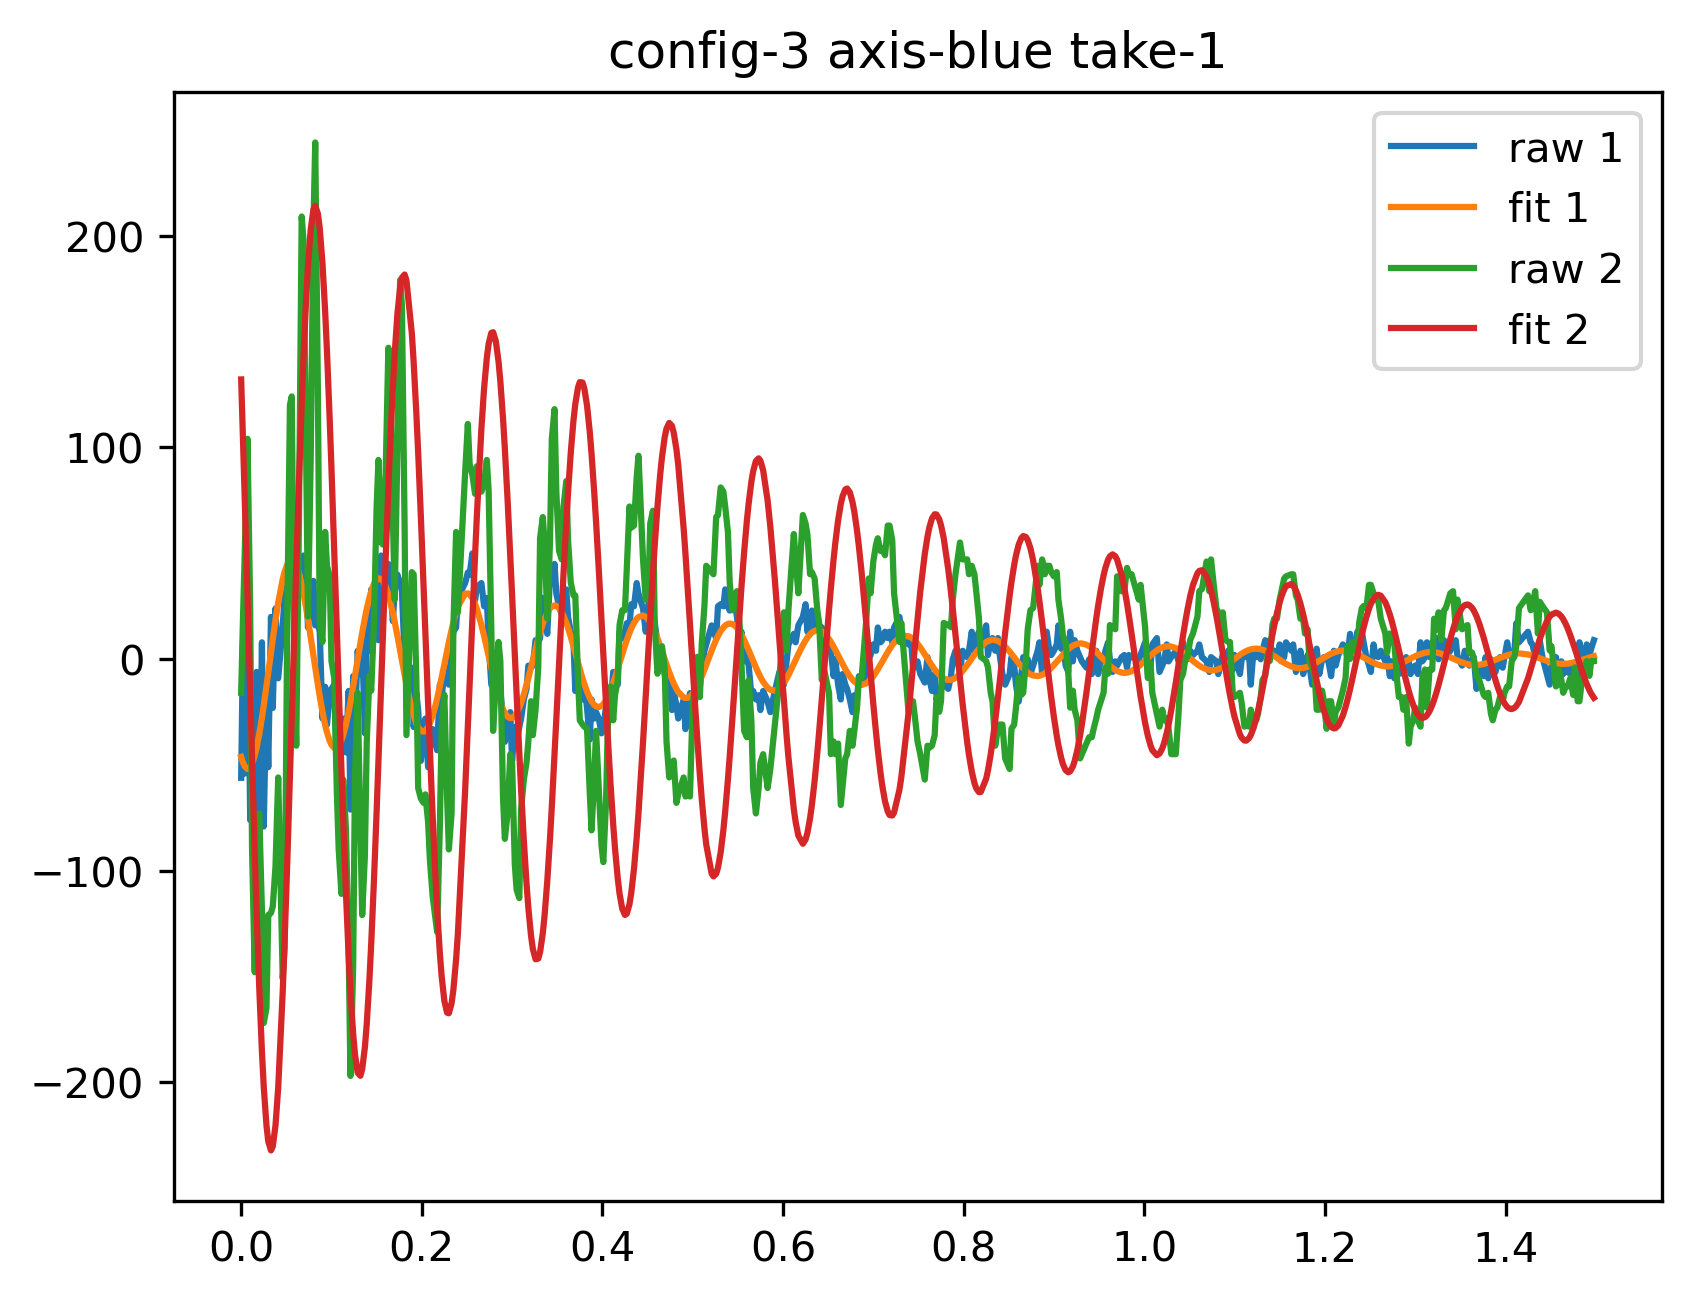

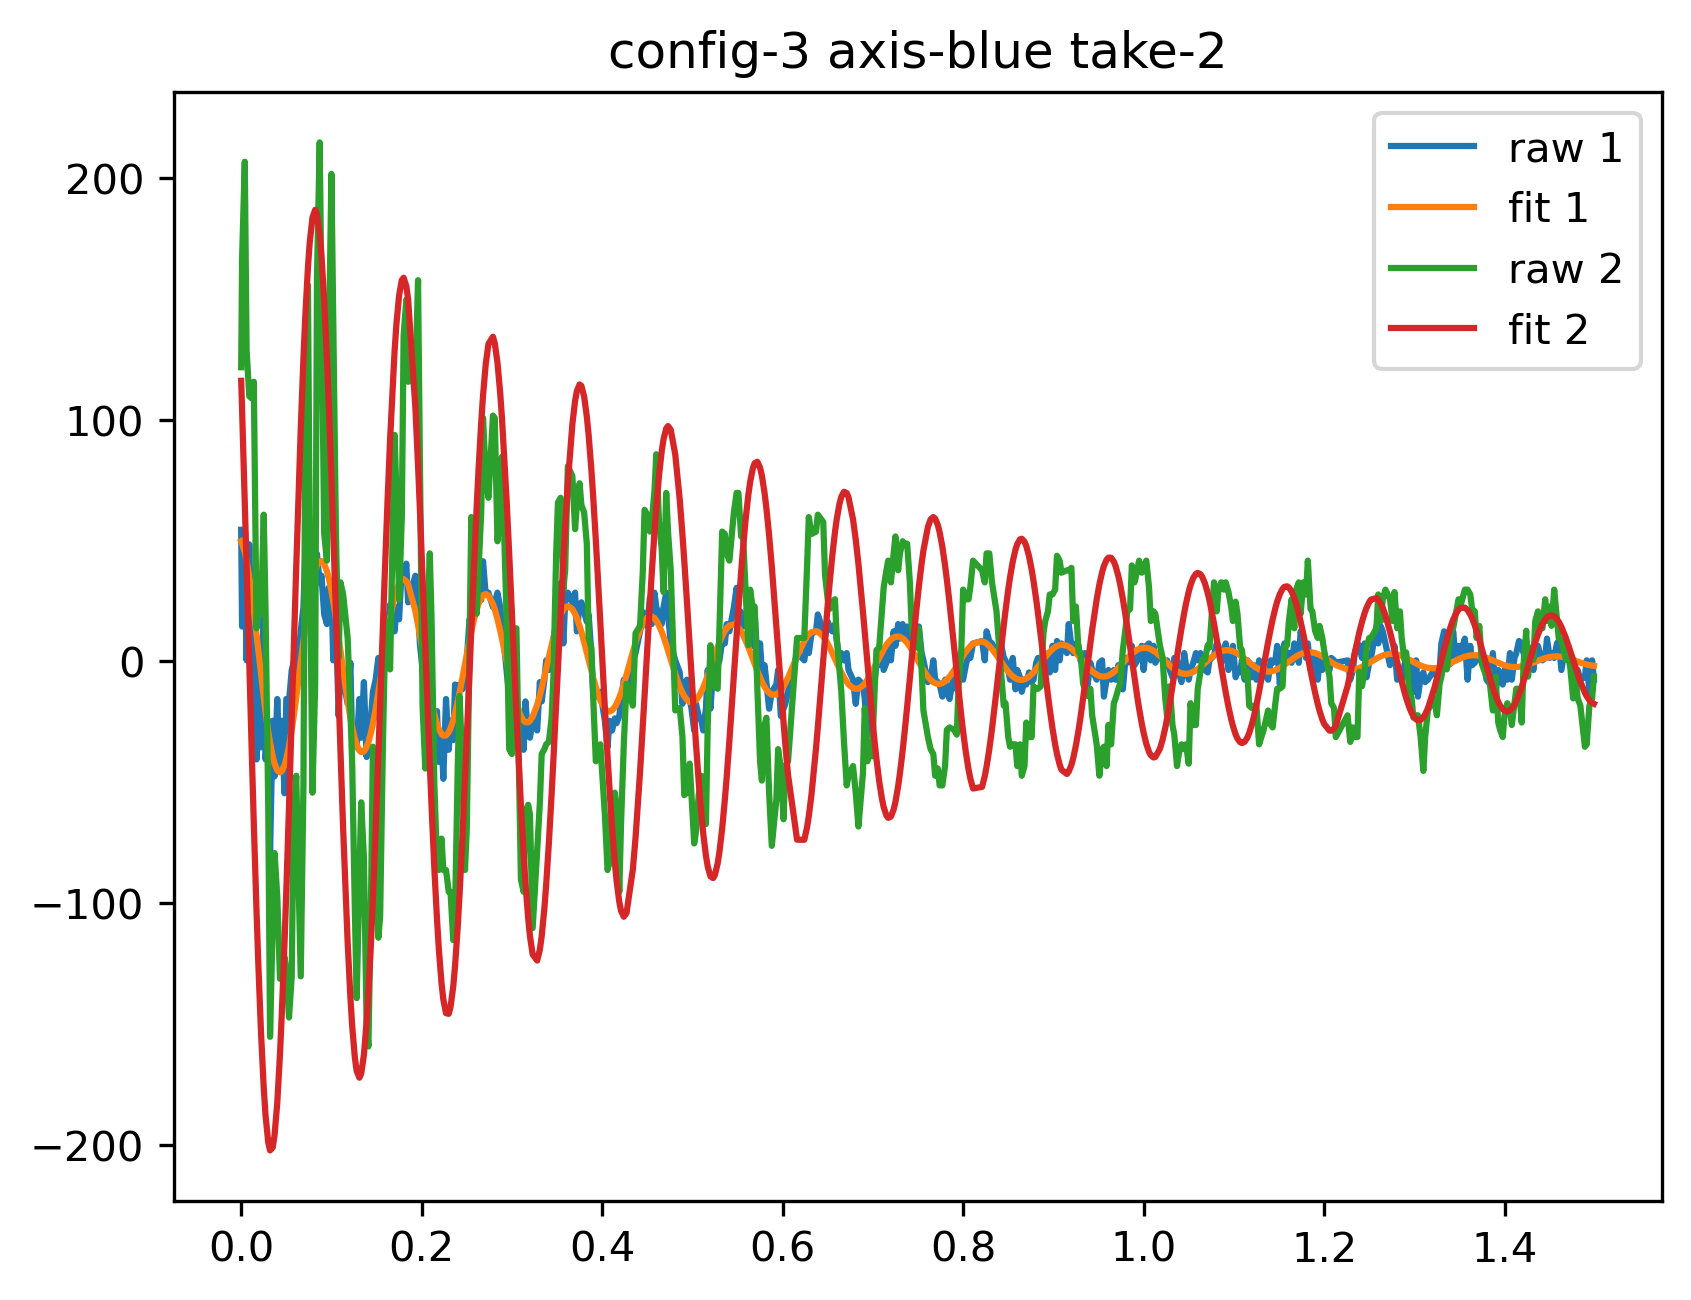

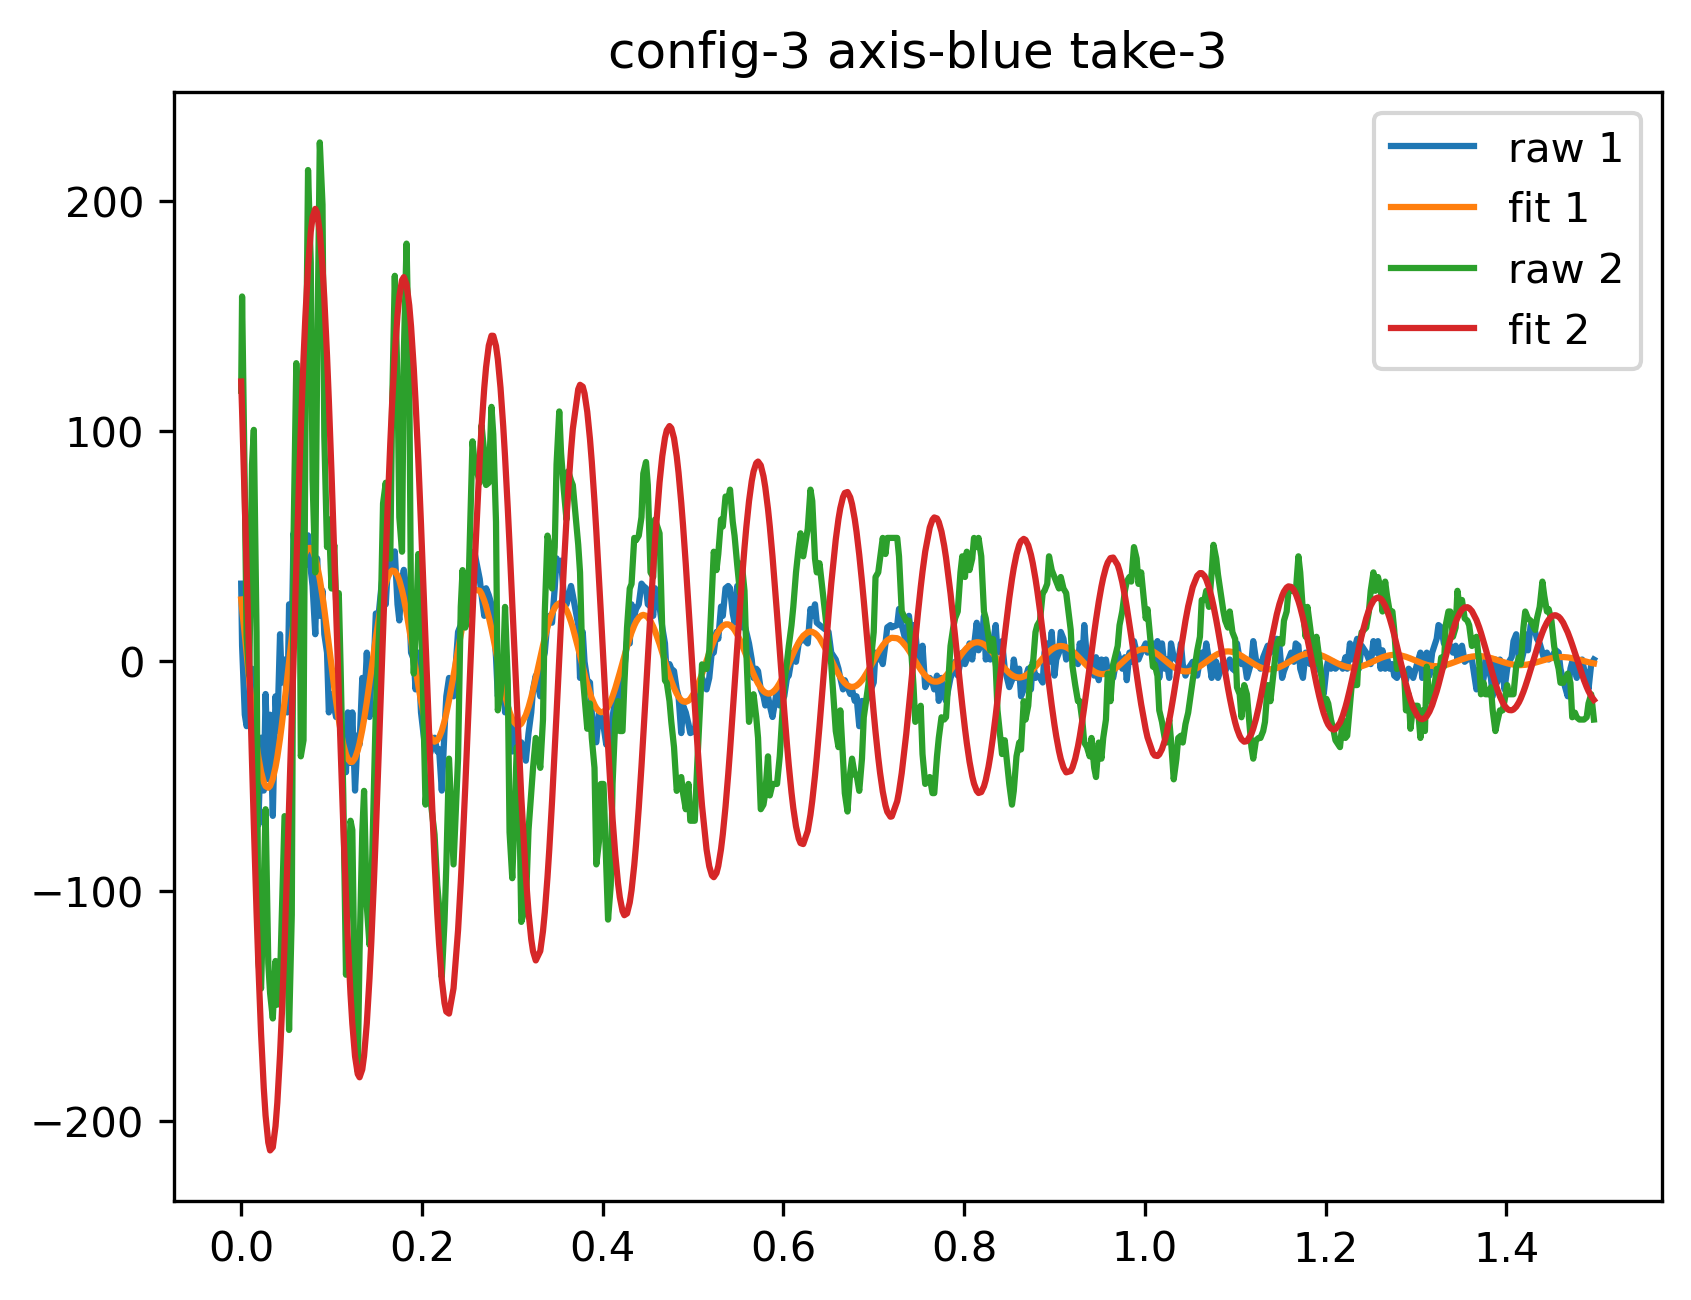

In [106]:
enum = 0
for conf_no, axis, take_no in itertools.product(configs, axes_color, takes):
    if conf_no != 3:
        continue
    print(conf_no, axis, take_no)
    raw_data = np.load(fname.format(conf_no, axis, take_no))
    selected_raw = clean_raw_data(raw_data)
    data = reduce_segment(selected_raw)
    t = data[:, 0] - data[0, 0]
    plt.figure(dpi=300)
    plt.title(f"config-{conf_no} axis-{axis} take-{take_no}")

    for col in y_col:
        y = data[:, col] - data[:, col].mean()
        # guess = np.array((np.abs(y).max(), 10.5, 1., y.mean(), 0.6))
        guess = np.array((np.abs(y).max(), 10.2, 1., 0.6))
        # if col == 2:
        #     guess = np.array((np.abs(y).max(), 10., 1., 0.6))
        pos = guess + np.random.randn(16, *guess.shape) * np.abs(guess) / 100
        nwalker, ndim = pos.shape
        sampler = emcee.EnsembleSampler(nwalker, ndim, log_prob, args=(t, y))
        sampler.run_mcmc(pos, 40000, progress=True)
        flat_samples = sampler.get_chain(discard=5000, thin=15, flat=True)
        fit_mean = flat_samples.mean(axis=0)
        fit_std = flat_samples.std(axis=0)
        print(fit_mean)
        print(fit_std)
        ################
        # res = opt.minimize(cost, (1000, 10, 0.1, -50, 0.1), (t, y))
        # print(res.x)
        plt.plot(t, y, label=f"raw {col}")
        plt.plot(t, model(fit_mean, t), label=f"fit {col}")
        ################
        # break
    plt.legend()
    if enum >= 5:
        break
    enum += 1
    

In [84]:
fit_theta

array([19.43287481,  0.5341084 ,  0.40465228,  0.68067776,  0.62097539])

Text(0.5, 0, 'step number')

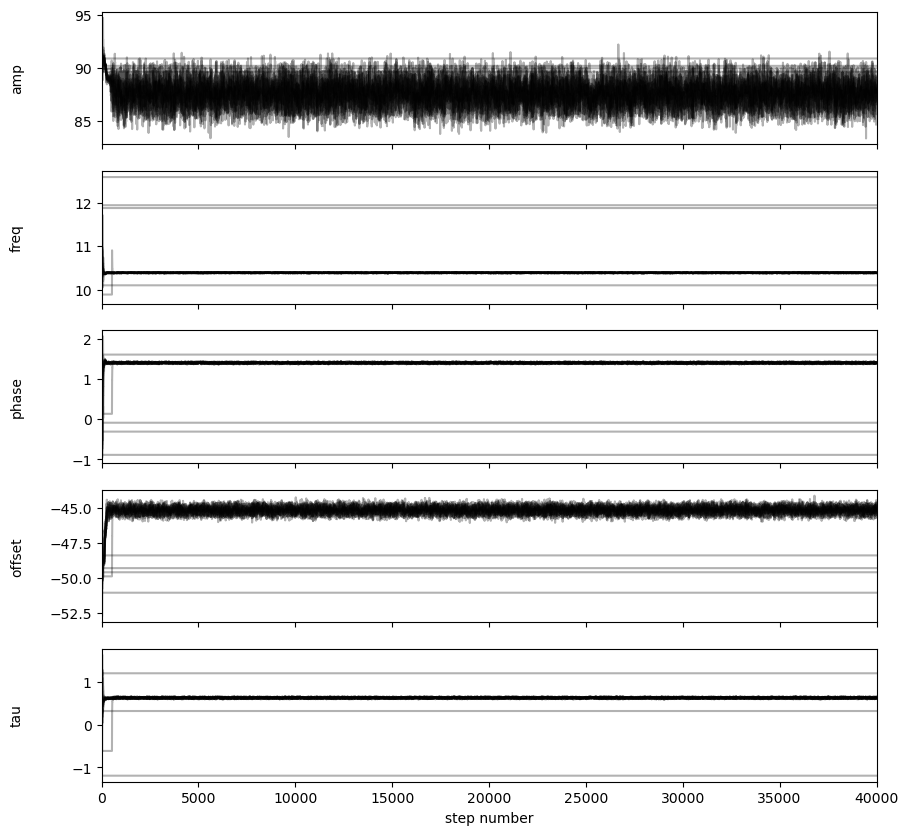

In [58]:
fig, axes = plt.subplots(5, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
labels = ["amp", "freq", "phase", "offset", "tau"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [59]:
tau = sampler.get_autocorr_time()
print(tau)

[nan nan  1. nan nan]


In [62]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

(41600, 5)


In [63]:
flat_samples.mean(axis=0)

array([ 88.24011441,  10.69721394,   1.06845863, -46.28357515,
         0.52561874])

In [64]:
flat_samples.std(axis=0)


array([1.42003362, 0.70625862, 0.73582942, 1.98673183, 0.47173579])

In [119]:
hit_ind = np.argmax(np.abs(tmp_data[:, 2]))
cut_seg = 300
valid_seg = 1500
start = hit_ind + cut_seg
end = start + valid_seg
selected_seg = tmp_data[start:end]

In [120]:
fit_ax = 2
test_data = selected_seg[:, fit_ax]
const_split = np.split(selected_seg, np.where(np.diff(test_data) != 0)[0] + 1)
clean_seg = np.concatenate([tmp[:1] for tmp in const_split], axis=0)
t = clean_seg[:, 0]
y = clean_seg[:, fit_ax]
res = opt.minimize(cost, (1000, 10, 0.1, -50, 0.1), (t, y))

In [106]:
res.x

array([328.3747727 ,  10.38829199,  -1.85446778, -45.17561341,
         0.62058275])

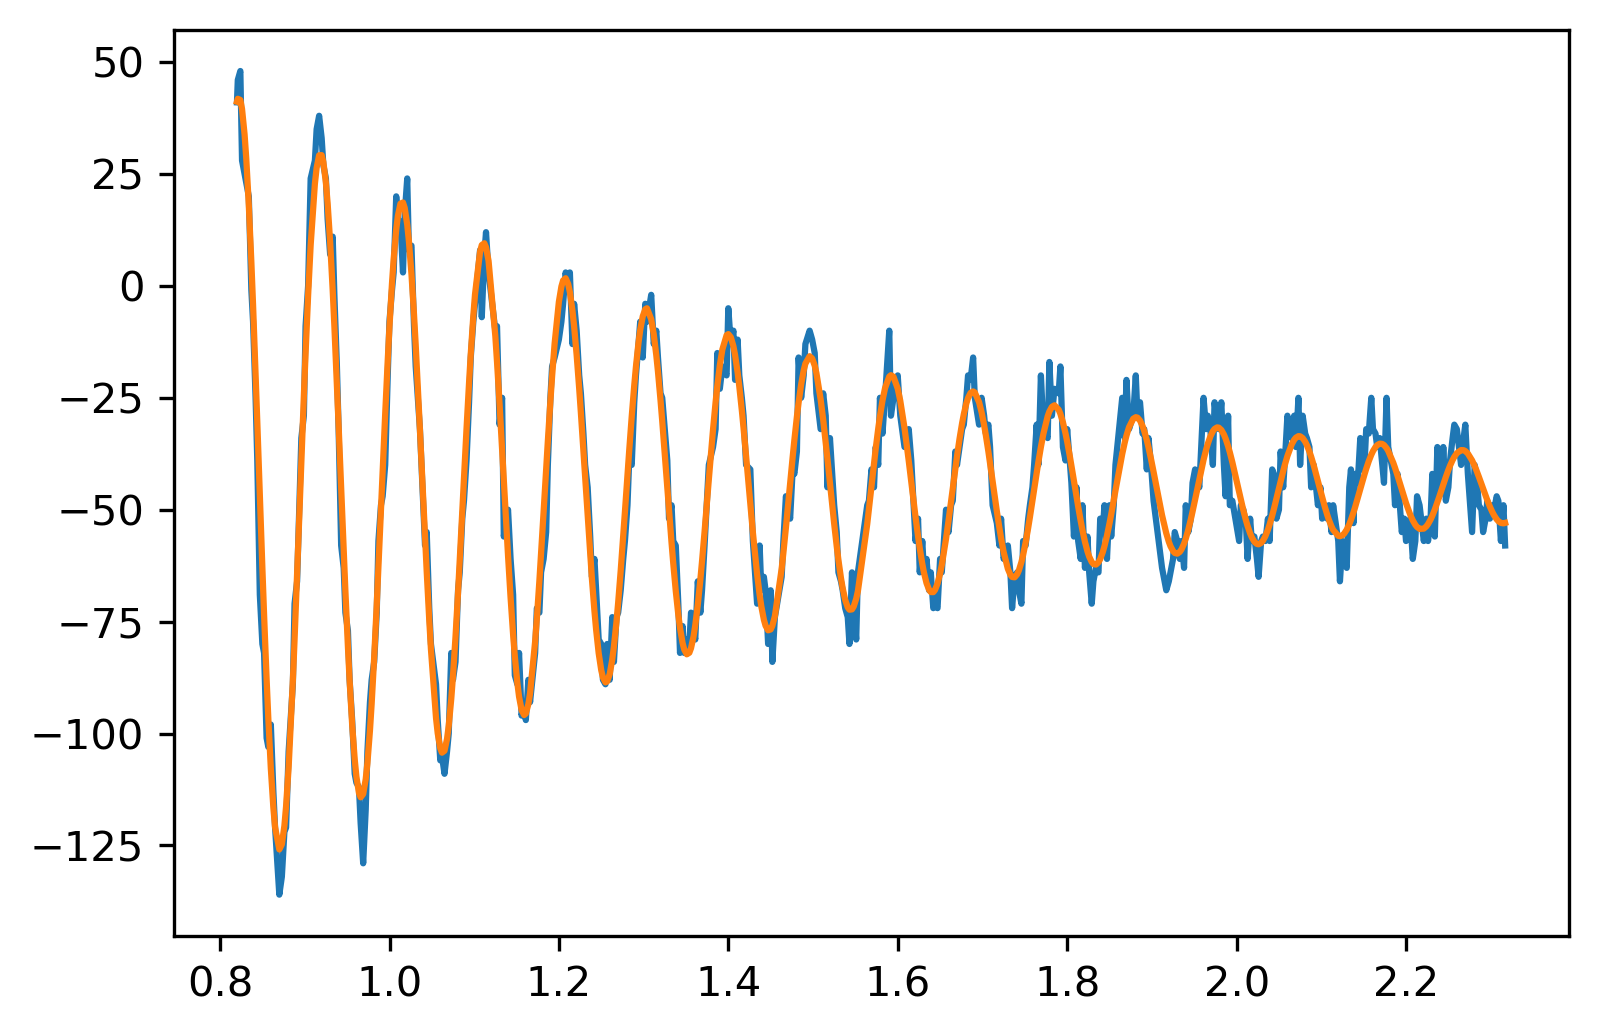

In [105]:
plt.figure(dpi=300)
plt.plot(t, y)
plt.plot(t, model(res.x, t))

In [121]:
y_bar = np.fft.fft(y - y.mean())
freqs = np.fft.fftfreq(y.shape[0], 1/400)

In [122]:
def gaussian(params, x):
    amp, sigma, loc, shift = params
    return amp * np.exp(- (x - loc)**2 / 2 / sigma**2) + shift

def gauss_cost(params, x, y):
    model = gaussian(params, x)
    return ((y - model)**2).sum()

In [123]:
data_mask = (freqs > 0) * (freqs < 30)
y = np.abs(y_bar[data_mask])
x = freqs[data_mask]
guess = (4000, 1, 10.7, 100)
res = opt.minimize(gauss_cost, guess, (x, y))

In [117]:
res.x

array([5.84584108e+03, 1.84860564e+00, 9.95256136e+00, 1.79982016e+04])

In [124]:
res.x

array([9.34137318e+03, 9.94254068e-01, 1.13823737e+01, 7.09279528e+02])

(0.0, 30.0)

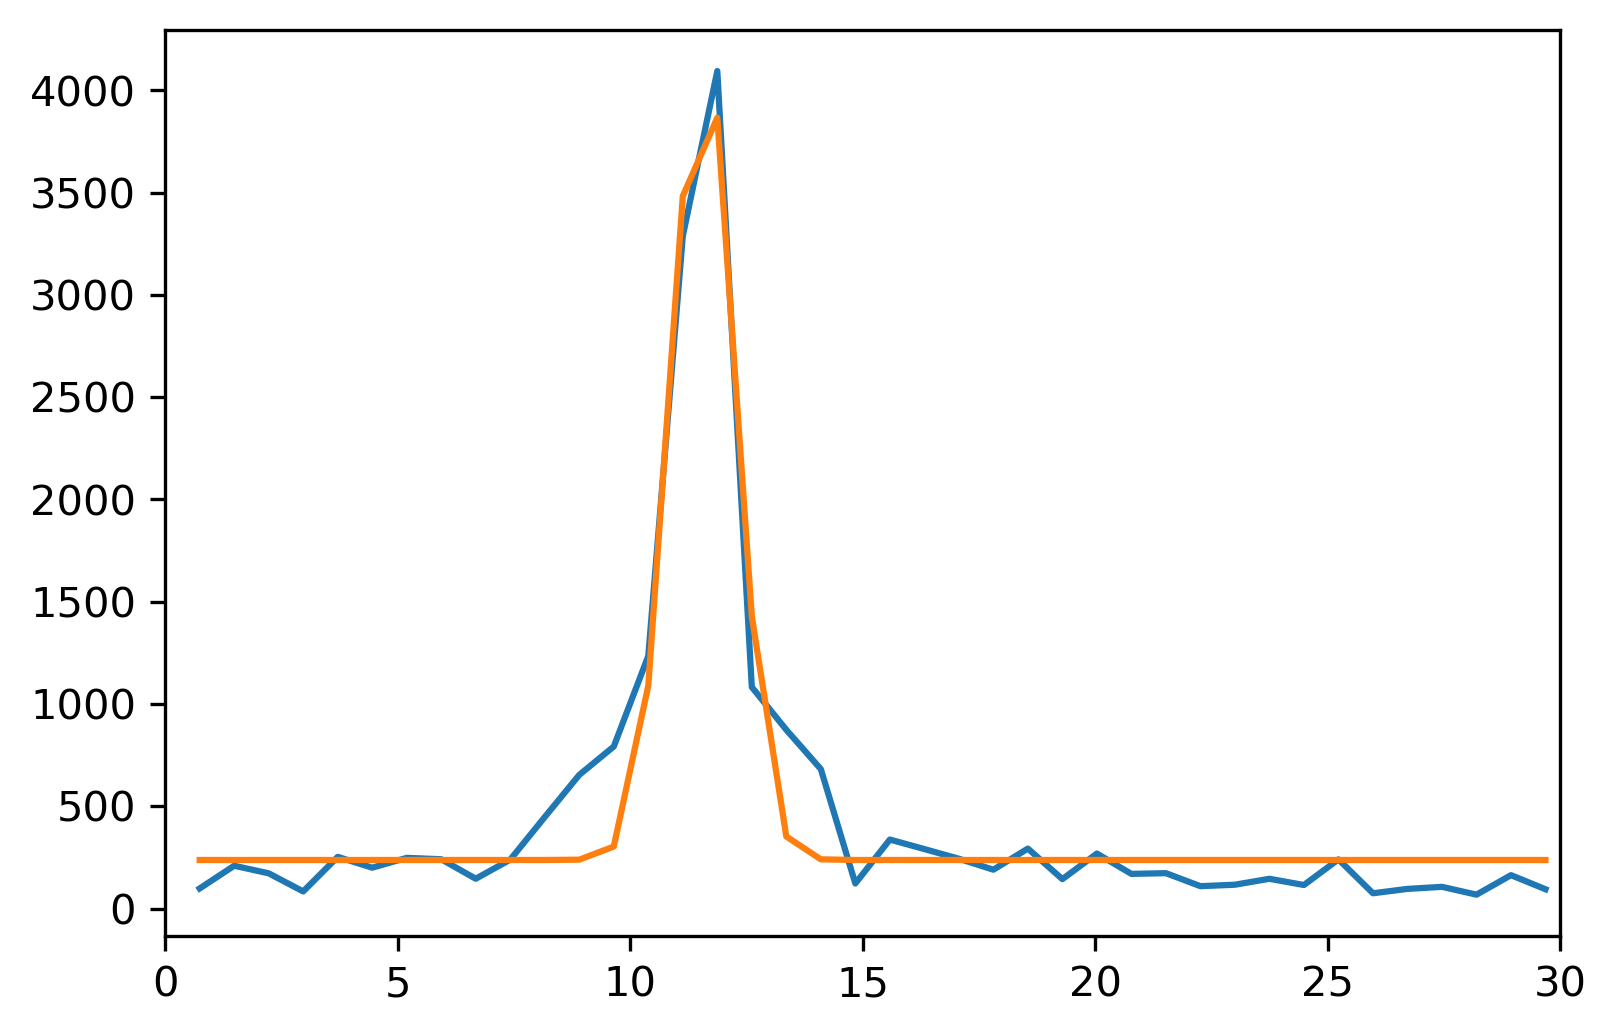

In [87]:
plt.figure(dpi=300)
# plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(np.abs(y_bar)))
plt.plot(x, y)
plt.plot(x, gaussian(res.x, x))
plt.xlim(0, 30)

In [49]:
freqs[np.argmax(np.abs(y_bar))]


11.873840445269018

In [36]:
res.x

array([132.45411066,  10.65977996,  -4.51185737, -44.89138648,
         1.03698997])

In [27]:
res.x

array([326.84684787,  10.54601147,  -5.86263996, -44.65519918,
         0.81457903])

In [37]:
np.diag(res.hess_inv) ** 0.5

array([0.01022382, 0.00053474, 0.00772065, 0.01704966, 0.00228248])

In [32]:
null_data = np.load(f"../data/norm_mode_null_test/NullTest_no_hit_take2.npy")[500:]

In [33]:
test_data = null_data[:, 2]
const_split = np.split(null_data, np.where(np.diff(test_data) != 0)[0] + 1)
clean_seg = np.concatenate([tmp[:1] for tmp in const_split], axis=0)

In [34]:
rms(clean_seg[:, 1])

4.978750455003622

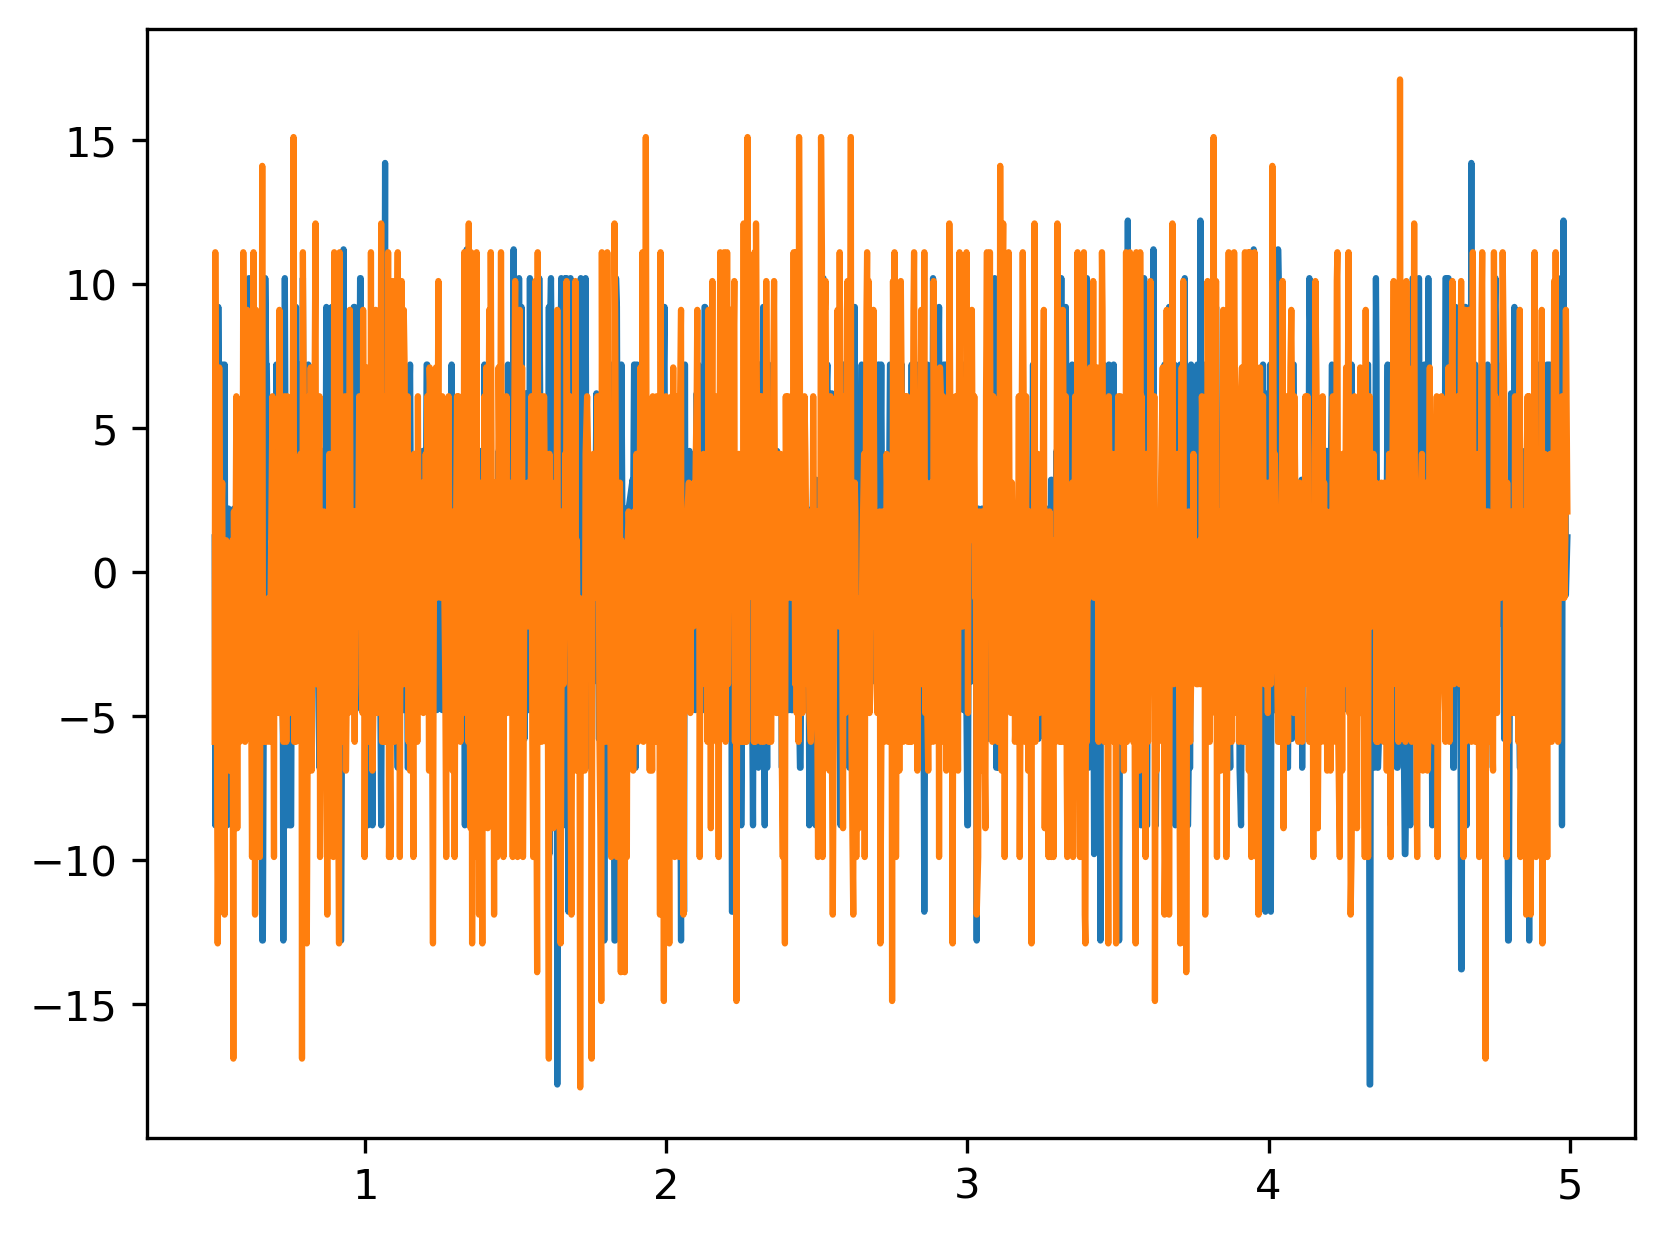

In [35]:
plt.figure(dpi=300)
plt.plot(clean_seg[:, 0], clean_seg[:, 1] - clean_seg[:, 1].mean())
plt.plot(clean_seg[:, 0], clean_seg[:, 2] - clean_seg[:, 2].mean())
# plt.plot(t, model(res.x, t))

In [21]:
rms(clean_seg[:, 1])

5.248181831953594

(0.0, 400000.0)

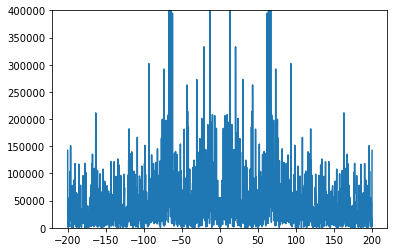

In [106]:
ps = np.abs(np.fft.fft(clean_seg[:, 1] - clean_seg[:, 1].mean()))**2
freqs = np.fft.fftfreq(clean_seg.shape[0], 1/400)
idx = np.argsort(freqs)
plt.plot(freqs[idx], ps[idx])
plt.ylim(0, 4e5)

(array([2.97420887e+05, 1.49394023e+05, 1.84761797e+01, 3.18216527e+01,
        3.67328893e+01, 4.03567240e+01, 3.29560709e+01, 2.13869962e+01,
        5.76798790e+01, 6.47455981e+01, 3.05064151e+01, 2.36198760e+01,
        2.87236189e+01, 5.36229494e+01, 4.36268188e+01, 3.05148888e+01,
        1.71469759e+01, 2.28592951e+01, 2.06109955e+01, 2.17998659e+01,
        1.05665629e+01, 1.47465850e+01, 2.31471039e+01, 1.77508953e+01,
        3.25094690e+00, 2.37671798e+01, 3.27783952e+01, 4.29195521e+01,
        1.72168496e+01, 1.54483995e+01, 2.17074440e+01, 2.03665955e+01,
        2.21851417e+01, 2.36010517e+01, 1.35971803e+01, 1.57584428e+01,
        3.52066799e+01, 5.56714229e+01, 4.74290503e+01, 4.26651913e+01,
        7.63664929e+01, 8.02467427e+01, 1.24776155e+02, 1.17421293e+02,
        5.40782066e+01, 2.14271371e+01, 2.54027300e+01, 5.07114297e+01,
        5.67439464e+01, 4.62388638e+01, 1.30875423e+01, 1.58087672e+01,
        1.93842477e+01, 2.46293766e+01, 2.41046547e+01, 1.747526

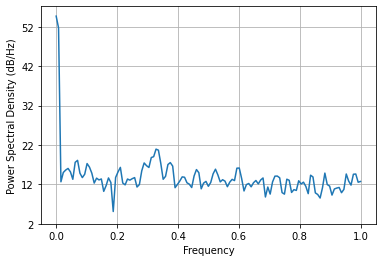

In [107]:
plt.psd(clean_seg[:, 1])

In [126]:
config_no = 1
take_no = 1
ax_dict = {'red':1 , 'blue':2}
for color in ('red', 'blue'):
    tmp_data = np.load(f"../data/norm_mode_null_test/NullTest_config{config_no}-{ax_no}-take{take_no}.npy")[500:]
    hit_ind = np.argmax(np.abs(tmp_data[:, 2]))
    cut_seg = 300
    valid_seg = 1500
    start = hit_ind + cut_seg
    end = start + valid_seg
    selected_seg = tmp_data[start:end]

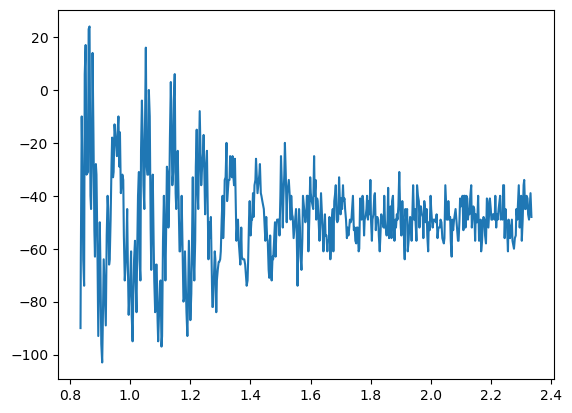

In [15]:
plt.plot(t, y)